### freeCodeCamp PyTorch Tutorial - Rice Text Classification
#### Reference: https://www.youtube.com/watch?v=E0bwEAWmVEM&t=5794s

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
df = pd.read_csv("riceClassification.csv")

In [29]:
df.shape

(18185, 11)

In [20]:
df.head(2)

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,18185.0,9093.000000,5249.701658,1.000000,4547.000000,9093.000000,13639.000000,18185.000000
Area,18185.0,7036.492989,1467.197150,2522.000000,5962.000000,6660.000000,8423.000000,10210.000000
MajorAxisLength,18185.0,151.680754,12.376402,74.133114,145.675910,153.883750,160.056214,183.211434
MinorAxisLength,18185.0,59.807851,10.061653,34.409894,51.393151,55.724288,70.156593,82.550762
Eccentricity,18185.0,0.915406,0.030575,0.676647,0.891617,0.923259,0.941372,0.966774
ConvexArea,18185.0,7225.817872,1502.006571,2579.000000,6125.000000,6843.000000,8645.000000,11008.000000
EquivDiameter,18185.0,94.132952,9.906250,56.666658,87.126656,92.085696,103.559146,114.016559
Extent,18185.0,0.616653,0.104389,0.383239,0.538530,0.601194,0.695664,0.886573
Perimeter,18185.0,351.606949,29.500620,197.015000,333.990000,353.088000,373.003000,508.511000
Roundness,18185.0,0.707998,0.067310,0.174590,0.650962,0.701941,0.769280,0.904748


In [27]:
df.drop(['id'], axis=1, inplace=True)

In [28]:
df.shape

(18185, 11)

In [33]:
df['Class'].unique()

array([1, 0])

In [34]:
df['Class'].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [36]:
#Max Normalization

original_df = df.copy()

for col in df.columns:
    df[col] = df[col]/df[col].abs().max()

df.head(3)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.66661,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.53037,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.54638,0.856278,0.412994,0.959862,0.374747,1.0


In [37]:
#Split into X and y target label
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

X.shape, y.shape

((18185, 10), (18185,))

In [42]:
#Split into train and test set with ration 7:3

#Train -> 70%, Valid: 15%, Test: 15%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12729, 10), (5456, 10), (12729,), (5456,))

In [43]:
#Split into train and test set with ration 1:1

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)
X_test.shape, X_val.shape, y_test.shape, y_val.shape

((2728, 10), (2728, 10), (2728,), (2728,))

### Dataset Object

In [45]:
class dataset(Dataset):

    #Convert to tensors + move to device
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X) #return shape of input

    #return full indexed row
    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [49]:
training_data = dataset(X_train, y_train)
val_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

### DataLoader for Batch Training

In [56]:
BATCH_SIZE = 8

In [57]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [55]:
for x, y in train_dataloader:
    print(x)
    print("---")
    print(y)
    break

tensor([[0.5649, 0.8092, 0.6152, 0.9718, 0.5392, 0.7516, 0.8733, 0.6645, 0.7017,
         0.7462],
        [0.8394, 0.8772, 0.8279, 0.9362, 0.7929, 0.9162, 0.6219, 0.7398, 0.8412,
         0.6011],
        [0.6032, 0.8616, 0.6197, 0.9785, 0.5845, 0.7767, 0.5492, 0.6841, 0.7068,
         0.7887],
        [0.6214, 0.8120, 0.6738, 0.9593, 0.5918, 0.7883, 0.5933, 0.6659, 0.7685,
         0.6837]])
---
tensor([1., 0., 1., 1.])


In [61]:
HIDDEN_NEURONS = 10
output_neuron = 1 #binary classif

class MyModel(nn.Module):

    #inherit
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, output_neuron)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x

model = MyModel().to(device)

    

In [62]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [70]:
#Loss function -> Binary Cross Entropy

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Train Model

In [72]:
total_train_loss = []
total_val_loss = []
total_train_acc = []
total_val_acc = []

EPOCHS = 10

In [100]:
for epoch in range(EPOCHS):
    
    total_batch_train_loss = 0
    total_batch_val_loss = 0
    total_batch_train_acc = 0
    total_batch_val_acc = 0
    
    model.train()
    for data in train_dataloader:
        inputs, labels = data

        #Forward Propagation
        prediction = model(inputs).squeeze(1) #Squeeze to resize tensor to 8 instead of (8,1)

        batch_loss = criterion(prediction, labels)
        total_batch_train_loss += batch_loss.item()

        batch_acc = (prediction.round() == labels).sum().item()
        total_batch_train_acc += batch_acc

        #Backprop + update gradients
        
        optimizer.zero_grad() #do not accumulate grads
        batch_loss.backward() #calculate gradients
        optimizer.step() #update weights
        

    #Validation Forward Propagation
    model.eval()
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)
            total_batch_val_loss += batch_loss.item()
            
            batch_acc = (prediction.round() == labels).sum().item()
            total_batch_val_acc += batch_acc  
            
    #Normalize train metrics + append
    epoch_train_loss = round(total_batch_train_loss/1000, 4)
    epoch_val_loss = round(total_batch_val_loss/1000, 4)
    epoch_train_acc = round(total_batch_train_acc/(training_data.__len__())*100, 4)
    epoch_val_acc = round(total_batch_val_acc/(val_data.__len__()) * 100 , 4)

    total_train_loss.append(epoch_train_loss)
    total_val_loss.append(epoch_val_loss)
    total_train_acc.append(epoch_train_acc)
    total_val_acc.append(epoch_val_acc)

    #print(f"{total_batch_train_acc}, {train_dataloader.__len__()} ,{total_batch_val_acc}, {val_dataloader.__len__()}")
    print(f"Epoch {epoch + 1}: Train Loss: {epoch_train_loss} | Train Acc: {epoch_train_acc} % | Val Loss: {epoch_val_loss} | Val Acc: {epoch_val_acc} %")    
    

Epoch 1: Train Loss: 0.0671 | Train Acc: 98.6802 % | Val Loss: 0.0104 | Val Acc: 98.9003 %
Epoch 2: Train Loss: 0.069 | Train Acc: 98.6016 % | Val Loss: 0.0109 | Val Acc: 98.8636 %
Epoch 3: Train Loss: 0.0682 | Train Acc: 98.5388 % | Val Loss: 0.0096 | Val Acc: 99.0469 %
Epoch 4: Train Loss: 0.0673 | Train Acc: 98.5859 % | Val Loss: 0.0097 | Val Acc: 99.0469 %
Epoch 5: Train Loss: 0.0671 | Train Acc: 98.6016 % | Val Loss: 0.0103 | Val Acc: 98.937 %
Epoch 6: Train Loss: 0.067 | Train Acc: 98.6016 % | Val Loss: 0.0096 | Val Acc: 99.1569 %
Epoch 7: Train Loss: 0.0674 | Train Acc: 98.688 % | Val Loss: 0.0101 | Val Acc: 98.9003 %
Epoch 8: Train Loss: 0.0664 | Train Acc: 98.6959 % | Val Loss: 0.0096 | Val Acc: 99.0836 %
Epoch 9: Train Loss: 0.0667 | Train Acc: 98.633 % | Val Loss: 0.0108 | Val Acc: 98.8636 %
Epoch 10: Train Loss: 0.0668 | Train Acc: 98.5859 % | Val Loss: 0.0096 | Val Acc: 99.0469 %


### Testing

In [101]:
model.eval()

with torch.no_grad():
    total_loss = 0
    total_acc = 0

    for data in test_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        total_loss += batch_loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc += acc
    acc_score = round(total_acc/test_data.__len__()*100, 2)
    print(f"Accuracy Score: {acc_score} %")
        

Accuracy Score: 98.86 %


### Vizualization

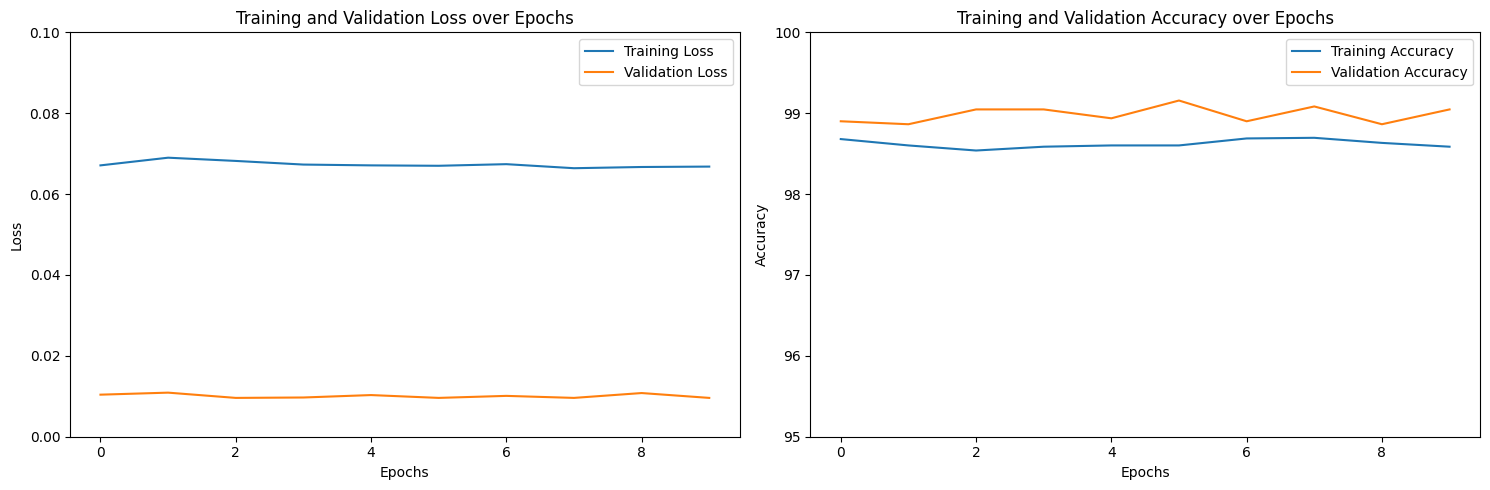

In [106]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_train_loss, label='Training Loss')
axs[0].plot(total_val_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 0.1])
axs[0].legend()

axs[1].plot(total_train_acc, label='Training Accuracy')
axs[1].plot(total_val_acc, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([95, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

### Inference

In [108]:
#Random Values
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]


Area:  2524
Major Axis Length:  145
Minor Axis Length:  56
Eccentricity:  0.919
Convex Area:  6518
EquivDiameter:  90.4
Extent:  0.85
Perimeter:  329.972
Roundness:  0.742
AspectRation:  2.55


[np.float64(0.24720861900097943),
 np.float64(0.7914353188427414),
 np.float64(0.6783704785014043),
 np.float64(0.9505844347846548),
 np.float64(0.5921148255813954),
 np.float64(0.7928672879937841),
 np.float64(0.9587478346499684),
 np.float64(0.6488984505743238),
 np.float64(0.8201175831714167),
 np.float64(0.6518663733251966)]

In [111]:
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = model(model_inputs)
pred_rounded = round(prediction.item())

print(f"Class is {pred_rounded}")

Class is 1
